# Clustering Small Set of News Sources

Junita Sirait

For case study purposes

In [162]:
import json
import pandas as pd
import csv
import numpy as np
import statistics

import tldextract

from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing

from sklearn.metrics import silhouette_score
from kneed import KneeLocator

from scipy.interpolate import make_interp_spline, BSpline

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

import math

from sklearn.feature_selection import SelectKBest
import os

<a id="sub1"></a>
## Subreddit data

In [247]:
pd = os.path.split(os.getcwd())[0]
data_fp = os.path.join(pd,"data/gm-newssources-subreddits")
dfp = os.path.join(pd,"data")
mbfc_path = os.path.join(pd, "data/mbfc")

In [248]:
with open (os.path.join(dfp,"gmm_intersection.json"), "r", encoding = "utf-8") as infile:
    gmm_intersection = json.load(infile)

In [249]:
len(gmm_intersection)

1631

In [250]:
with open (os.path.join(dfp,"gm_intersection.json"), "r", encoding = "utf-8") as infile:
    gm_intersection = json.load(infile)

In [251]:
len(gm_intersection)

42477

In [252]:
non_news = []
with open("non_news.csv", "r", encoding="utf-8") as nn:
    r = csv.reader(nn, delimiter=",")
    counter = 0
    for row in r:
        if counter != 0:
            non_news.append(row[0])
        counter += 1
len(non_news)

130

In [253]:
# Reading in all the subreddits in our files

with open(os.path.join(data_fp,"subreddit_ns_2021-01.json"), "r", encoding = "utf-8") as infile1a:
    subreddit_ns_jan = json.load(infile1a)

with open(os.path.join(data_fp,"subreddit_ns_2021-02.json"), "r", encoding = "utf-8") as infile2a:
    subreddit_ns_feb = json.load(infile2a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-03.json"), "r", encoding = "utf-8") as infile3a:
    subreddit_ns_march = json.load(infile3a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-04.json"), "r", encoding = "utf-8") as infile4a:
    subreddit_ns_april = json.load(infile4a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-05.json"), "r", encoding = "utf-8") as infile5a:
    subreddit_ns_may = json.load(infile5a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-06.json"), "r", encoding = "utf-8") as infile6a:
    subreddit_ns_jun = json.load(infile6a)

In [254]:
# ns_subreddit
with open(os.path.join(data_fp,"ns_subreddit_2021-01.json")) as infile1:
    ns_subreddit_01 = json.load(infile1)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-02.json")) as infile2:
    ns_subreddit_02 = json.load(infile2)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-03.json")) as infile3:
    ns_subreddit_03 = json.load(infile3)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-04.json")) as infile4:
    ns_subreddit_04 = json.load(infile4)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-05.json")) as infile5:
    ns_subreddit_05 = json.load(infile5)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-06.json")) as infile6:
    ns_subreddit_06 = json.load(infile6)

## Apparently for some reason Reddit indexes many users as subreddits

In [256]:
sr_union_old = (
      set(subreddit_ns_jan) | set(subreddit_ns_feb) |
      set(subreddit_ns_march) | set(subreddit_ns_april) |
      set(subreddit_ns_may) | set(subreddit_ns_jun))

In [258]:
u_s = [s for s in sr_union_old if s.startswith("u_")]
len(u_s)

910554

In [259]:
u_s[:5]

['u_AluminumRyRy',
 'u_allykitten584',
 'u_Kysonnora',
 'u_OftenSarcastic',
 'u_PalpitationSad2273']

In [260]:
"u_toronto_news" in u_s

True

## Let's exclude `u_*` from our subreddits and non_news from our news sources

In [261]:
files_sub = [subreddit_ns_jan, subreddit_ns_feb, subreddit_ns_march, subreddit_ns_april, subreddit_ns_may, subreddit_ns_jun]
files_ns = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]

Removing from files_sub

In [262]:
for f in files_sub:
    [f.pop(u) for u in u_s if u in f]

In [263]:
for f in files_sub:
    for n in f:
        if 'reddit.com' in f[n]: f[n].pop('reddit.com')
        # removing each of the non_news
        for nns in non_news:
            if nns in f[n]: f[n].pop(nns)
    print("Done for a file")

Done for a file
Done for a file
Done for a file
Done for a file
Done for a file
Done for a file


In [264]:
"learnwelsh" in subreddit_ns_jan

True

Now that we have removed non_news from various subreddits, there would be subreddits that now does not have anything inside. Let's get rid of these subreddits as well.

In [267]:
for s in files_sub:
    empty_subs = set()
    for k in s:
        if len(s[k]) == 0: empty_subs.add(k)
    print(len(empty_subs))
    [s.pop(u) for u in empty_subs]
    print("done for a file")

183592
done for a file
184349
done for a file
203649
done for a file
210354
done for a file
247206
done for a file
263501
done for a file


Instead of removing from files_ns, I will reconstruct files_ns from files_sub.

In [269]:
def ns_from_sub(subfile):
    d = defaultdict(dict)
    for sub in subfile:
        for n in subfile[sub]:
            d[n][sub] = subfile[sub][n]
    return d

In [270]:
ns_subreddit_01 = ns_from_sub(subreddit_ns_jan)
ns_subreddit_02 = ns_from_sub(subreddit_ns_feb)
ns_subreddit_03 = ns_from_sub(subreddit_ns_march)
ns_subreddit_04 = ns_from_sub(subreddit_ns_april)
ns_subreddit_05 = ns_from_sub(subreddit_ns_may)
ns_subreddit_06 = ns_from_sub(subreddit_ns_jun)

In [271]:
'reddit.com' in ns_subreddit_02

False

Let's use the intersection in an alphabetical order as a fixed order of our subreddits.

In [272]:
subs = sorted(set(subreddit_ns_jan) & set(subreddit_ns_feb) &
      set(subreddit_ns_march) & set(subreddit_ns_april) &
      set(subreddit_ns_may) & set(subreddit_ns_jun))

In [273]:
subs[:5]

['0xProject', '1001Movies', '100movies365days', '100yearsago', '12thMan']

## Intersections and unions of subreddits

In [274]:
# what about their intersection?
sr_intersection = (
      set(subreddit_ns_jan) & set(subreddit_ns_feb) &
      set(subreddit_ns_march) & set(subreddit_ns_april) &
      set(subreddit_ns_may) & set(subreddit_ns_jun))

print("intersection:", len(sr_intersection))

intersection: 10194


In [275]:
sr_union = (
      set(subreddit_ns_jan) | set(subreddit_ns_feb) |
      set(subreddit_ns_march) | set(subreddit_ns_april) |
      set(subreddit_ns_may) | set(subreddit_ns_jun))

print("union:", len(sr_union))

union: 68224


In [276]:
"learnwelsh" in sr_union

True

<a id="sub2"></a>
## News sources data

How many news sources are there?

In [277]:
# union
ns_union = (set(ns_subreddit_01) |
       set(ns_subreddit_02) |
       set(ns_subreddit_03) |
       set(ns_subreddit_04) |
       set(ns_subreddit_05) |
       set(ns_subreddit_06))

len(ns_union)

23776

In [278]:
nss = (set(ns_subreddit_01) &
       set(ns_subreddit_02) &
       set(ns_subreddit_03) &
       set(ns_subreddit_04) &
       set(ns_subreddit_05) &
       set(ns_subreddit_06))

In [279]:
num_ns = len(nss)
num_ns

8835

## For each news source, let's count in how many subreddits they appear

In [280]:
subreddit_count = dict()
for ns in ns_union:
    subreddit_count[ns] = len(set(ns_subreddit_01.get(ns, dict()).keys()) 
                               | set(ns_subreddit_02.get(ns, dict()).keys()) 
                               | set(ns_subreddit_03.get(ns, dict()).keys()) 
                               | set(ns_subreddit_04.get(ns, dict()).keys())
                               | set(ns_subreddit_05.get(ns, dict()).keys()) 
                               | set(ns_subreddit_06.get(ns, dict()).keys()))

`subreddit_count` stores in how many subreddits each news source appears.

In [281]:
subreddit_count['nytimes.com']

6085

In [282]:
subreddit_count_freq = dict(Counter(subreddit_count.values()).most_common())
subreddit_count_freq

{1: 4649,
 2: 2791,
 3: 1934,
 4: 1420,
 5: 1123,
 6: 929,
 7: 778,
 8: 675,
 9: 542,
 10: 475,
 11: 441,
 12: 358,
 14: 346,
 13: 328,
 15: 306,
 16: 272,
 17: 244,
 18: 223,
 21: 194,
 22: 192,
 19: 188,
 20: 184,
 24: 148,
 25: 140,
 23: 130,
 27: 125,
 26: 117,
 30: 115,
 31: 104,
 29: 102,
 33: 101,
 28: 101,
 35: 86,
 34: 85,
 32: 81,
 38: 80,
 37: 75,
 42: 68,
 41: 66,
 39: 65,
 48: 64,
 36: 63,
 49: 60,
 46: 60,
 43: 59,
 40: 59,
 45: 59,
 47: 57,
 53: 54,
 44: 53,
 54: 50,
 55: 49,
 57: 47,
 50: 44,
 56: 43,
 74: 41,
 64: 38,
 59: 37,
 61: 36,
 51: 35,
 52: 35,
 63: 33,
 91: 33,
 69: 30,
 76: 29,
 72: 28,
 71: 28,
 70: 27,
 67: 27,
 81: 27,
 62: 27,
 66: 27,
 58: 26,
 60: 26,
 73: 26,
 65: 25,
 87: 24,
 84: 24,
 78: 22,
 75: 22,
 94: 22,
 89: 22,
 82: 21,
 68: 21,
 79: 20,
 96: 20,
 88: 19,
 86: 19,
 77: 19,
 105: 19,
 113: 18,
 103: 18,
 106: 18,
 92: 18,
 80: 17,
 85: 16,
 104: 16,
 90: 15,
 93: 15,
 101: 15,
 114: 15,
 120: 15,
 100: 15,
 141: 14,
 135: 14,
 108: 13,
 111: 

`subreddit_count_freq` keeps track of how many news sources appear in *n* subreddits for all possible *n*.

In [283]:
max(subreddit_count_freq.keys())

6309

In [284]:
sde_ranked = Counter(subreddit_count).most_common()

for t in sde_ranked[:20]:
    sr, co = t
    if co > 1:
        print(f"{sr} is mentioned in {co} subreddits.")

theguardian.com is mentioned in 6309 subreddits.
nytimes.com is mentioned in 6085 subreddits.
cnn.com is mentioned in 5588 subreddits.
bbc.com is mentioned in 4680 subreddits.
fandom.com is mentioned in 4586 subreddits.
reuters.com is mentioned in 4180 subreddits.
washingtonpost.com is mentioned in 3958 subreddits.
forbes.com is mentioned in 3872 subreddits.
cnbc.com is mentioned in 3665 subreddits.
bloomberg.com is mentioned in 3556 subreddits.
bbc.co.uk is mentioned in 3400 subreddits.
businessinsider.com is mentioned in 3309 subreddits.
apnews.com is mentioned in 3293 subreddits.
npr.org is mentioned in 3166 subreddits.
nbcnews.com is mentioned in 2997 subreddits.
dailymail.co.uk is mentioned in 2979 subreddits.
independent.co.uk is mentioned in 2903 subreddits.
msn.com is mentioned in 2889 subreddits.
vice.com is mentioned in 2845 subreddits.
nih.gov is mentioned in 2663 subreddits.


In [285]:
print([k for k in ns_union if "wiki" in k])

['wikileaks-kr.org', 'sportzwiki.com', 'wikinews.org', 'catawiki.com', 'semiwiki.com', 'wikia.com', 'wikichip.org', 'wikileaf.com']


In [286]:
sc = [s for s in subreddit_count if subreddit_count[s]>=300]
len(sc)

428

In [287]:
with open("sc_ge3k.csv", "w", newline='', encoding="utf-8") as s:
    w = csv.writer(s, dialect="excel", delimiter=",")
    for c in sc:
        w.writerow([c])

In [288]:
sum(subreddit_count_freq.values()) == len(ns_union)

True

In [289]:
import itertools

In [290]:
scf = list(itertools.chain.from_iterable(itertools.repeat(k,v) for k,v in subreddit_count_freq.items()))

Text(0.5, 1.0, 'number of news sources appearing in x subreddits')

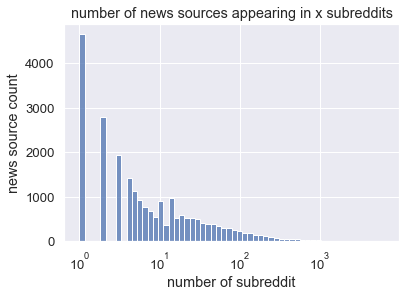

In [291]:
# sns.histplot([math.log(s,10) for s in scf])
sns.histplot(scf, log_scale=True)
plt.xlabel("number of subreddit")
plt.ylabel("news source count")
plt.title("number of news sources appearing in x subreddits")

How many news sources only appear in 10 subreddits or less? what about 9 or 8?

In [292]:
def pct_ns_in_k_subreddits(ks):
    ns_in_i_subreddit = [k for k in subreddit_count if subreddit_count[k] <= ks]
    count = len(ns_in_i_subreddit)
    print("There are {} news sources appearing in only {} subreddits or less ({}%)".format(count, ks, count/len(ns_union)))
    return count/len(ns_union)

In [293]:
pct_ns_in_k_subreddits(5)

There are 11917 news sources appearing in only 5 subreddits or less (0.5012197173620457%)


0.5012197173620457

In [294]:
pct_in_k_subreddits = [(i, pct_ns_in_k_subreddits(i)) for i in range(1000)]

There are 0 news sources appearing in only 0 subreddits or less (0.0%)
There are 4649 news sources appearing in only 1 subreddits or less (0.19553331090174966%)
There are 7440 news sources appearing in only 2 subreddits or less (0.31292059219380886%)
There are 9374 news sources appearing in only 3 subreddits or less (0.39426312247644685%)
There are 10794 news sources appearing in only 4 subreddits or less (0.45398721399730824%)
There are 11917 news sources appearing in only 5 subreddits or less (0.5012197173620457%)
There are 12846 news sources appearing in only 6 subreddits or less (0.540292732166891%)
There are 13624 news sources appearing in only 7 subreddits or less (0.573014804845222%)
There are 14299 news sources appearing in only 8 subreddits or less (0.6014047779273217%)
There are 14841 news sources appearing in only 9 subreddits or less (0.6242008748317631%)
There are 15316 news sources appearing in only 10 subreddits or less (0.644179004037685%)
There are 15757 news sources a

There are 22318 news sources appearing in only 103 subreddits or less (0.9386776581426649%)
There are 22334 news sources appearing in only 104 subreddits or less (0.9393506056527591%)
There are 22353 news sources appearing in only 105 subreddits or less (0.940149730820996%)
There are 22371 news sources appearing in only 106 subreddits or less (0.940906796769852%)
There are 22382 news sources appearing in only 107 subreddits or less (0.9413694481830417%)
There are 22395 news sources appearing in only 108 subreddits or less (0.9419162180349933%)
There are 22408 news sources appearing in only 109 subreddits or less (0.9424629878869448%)
There are 22418 news sources appearing in only 110 subreddits or less (0.9428835800807537%)
There are 22431 news sources appearing in only 111 subreddits or less (0.9434303499327052%)
There are 22439 news sources appearing in only 112 subreddits or less (0.9437668236877523%)
There are 22457 news sources appearing in only 113 subreddits or less (0.944523889

There are 23078 news sources appearing in only 204 subreddits or less (0.97064266487214%)
There are 23080 news sources appearing in only 205 subreddits or less (0.9707267833109018%)
There are 23088 news sources appearing in only 206 subreddits or less (0.9710632570659489%)
There are 23092 news sources appearing in only 207 subreddits or less (0.9712314939434724%)
There are 23092 news sources appearing in only 208 subreddits or less (0.9712314939434724%)
There are 23095 news sources appearing in only 209 subreddits or less (0.9713576716016151%)
There are 23100 news sources appearing in only 210 subreddits or less (0.9715679676985195%)
There are 23103 news sources appearing in only 211 subreddits or less (0.9716941453566622%)
There are 23106 news sources appearing in only 212 subreddits or less (0.9718203230148048%)
There are 23110 news sources appearing in only 213 subreddits or less (0.9719885598923284%)
There are 23111 news sources appearing in only 214 subreddits or less (0.972030619

There are 23367 news sources appearing in only 308 subreddits or less (0.9827977792732167%)
There are 23370 news sources appearing in only 309 subreddits or less (0.9829239569313594%)
There are 23372 news sources appearing in only 310 subreddits or less (0.9830080753701211%)
There are 23372 news sources appearing in only 311 subreddits or less (0.9830080753701211%)
There are 23373 news sources appearing in only 312 subreddits or less (0.983050134589502%)
There are 23373 news sources appearing in only 313 subreddits or less (0.983050134589502%)
There are 23375 news sources appearing in only 314 subreddits or less (0.9831342530282638%)
There are 23376 news sources appearing in only 315 subreddits or less (0.9831763122476447%)
There are 23376 news sources appearing in only 316 subreddits or less (0.9831763122476447%)
There are 23377 news sources appearing in only 317 subreddits or less (0.9832183714670256%)
There are 23377 news sources appearing in only 318 subreddits or less (0.983218371

There are 23475 news sources appearing in only 412 subreddits or less (0.9873401749663526%)
There are 23477 news sources appearing in only 413 subreddits or less (0.9874242934051144%)
There are 23478 news sources appearing in only 414 subreddits or less (0.9874663526244953%)
There are 23478 news sources appearing in only 415 subreddits or less (0.9874663526244953%)
There are 23479 news sources appearing in only 416 subreddits or less (0.9875084118438762%)
There are 23479 news sources appearing in only 417 subreddits or less (0.9875084118438762%)
There are 23481 news sources appearing in only 418 subreddits or less (0.9875925302826379%)
There are 23482 news sources appearing in only 419 subreddits or less (0.9876345895020189%)
There are 23483 news sources appearing in only 420 subreddits or less (0.9876766487213997%)
There are 23483 news sources appearing in only 421 subreddits or less (0.9876766487213997%)
There are 23483 news sources appearing in only 422 subreddits or less (0.9876766

There are 23555 news sources appearing in only 522 subreddits or less (0.9907049125168237%)
There are 23556 news sources appearing in only 523 subreddits or less (0.9907469717362046%)
There are 23559 news sources appearing in only 524 subreddits or less (0.9908731493943472%)
There are 23559 news sources appearing in only 525 subreddits or less (0.9908731493943472%)
There are 23559 news sources appearing in only 526 subreddits or less (0.9908731493943472%)
There are 23559 news sources appearing in only 527 subreddits or less (0.9908731493943472%)
There are 23559 news sources appearing in only 528 subreddits or less (0.9908731493943472%)
There are 23560 news sources appearing in only 529 subreddits or less (0.9909152086137282%)
There are 23561 news sources appearing in only 530 subreddits or less (0.990957267833109%)
There are 23562 news sources appearing in only 531 subreddits or less (0.9909993270524899%)
There are 23562 news sources appearing in only 532 subreddits or less (0.99099932

There are 23593 news sources appearing in only 611 subreddits or less (0.9923031628532974%)
There are 23593 news sources appearing in only 612 subreddits or less (0.9923031628532974%)
There are 23593 news sources appearing in only 613 subreddits or less (0.9923031628532974%)
There are 23593 news sources appearing in only 614 subreddits or less (0.9923031628532974%)
There are 23593 news sources appearing in only 615 subreddits or less (0.9923031628532974%)
There are 23593 news sources appearing in only 616 subreddits or less (0.9923031628532974%)
There are 23593 news sources appearing in only 617 subreddits or less (0.9923031628532974%)
There are 23593 news sources appearing in only 618 subreddits or less (0.9923031628532974%)
There are 23595 news sources appearing in only 619 subreddits or less (0.9923872812920592%)
There are 23596 news sources appearing in only 620 subreddits or less (0.9924293405114402%)
There are 23597 news sources appearing in only 621 subreddits or less (0.9924713

There are 23630 news sources appearing in only 720 subreddits or less (0.9938593539703903%)
There are 23632 news sources appearing in only 721 subreddits or less (0.993943472409152%)
There are 23632 news sources appearing in only 722 subreddits or less (0.993943472409152%)
There are 23633 news sources appearing in only 723 subreddits or less (0.993985531628533%)
There are 23634 news sources appearing in only 724 subreddits or less (0.9940275908479138%)
There are 23634 news sources appearing in only 725 subreddits or less (0.9940275908479138%)
There are 23634 news sources appearing in only 726 subreddits or less (0.9940275908479138%)
There are 23634 news sources appearing in only 727 subreddits or less (0.9940275908479138%)
There are 23634 news sources appearing in only 728 subreddits or less (0.9940275908479138%)
There are 23634 news sources appearing in only 729 subreddits or less (0.9940275908479138%)
There are 23634 news sources appearing in only 730 subreddits or less (0.9940275908

There are 23659 news sources appearing in only 828 subreddits or less (0.9950790713324361%)
There are 23659 news sources appearing in only 829 subreddits or less (0.9950790713324361%)
There are 23660 news sources appearing in only 830 subreddits or less (0.995121130551817%)
There are 23660 news sources appearing in only 831 subreddits or less (0.995121130551817%)
There are 23660 news sources appearing in only 832 subreddits or less (0.995121130551817%)
There are 23660 news sources appearing in only 833 subreddits or less (0.995121130551817%)
There are 23660 news sources appearing in only 834 subreddits or less (0.995121130551817%)
There are 23661 news sources appearing in only 835 subreddits or less (0.9951631897711979%)
There are 23662 news sources appearing in only 836 subreddits or less (0.9952052489905787%)
There are 23662 news sources appearing in only 837 subreddits or less (0.9952052489905787%)
There are 23663 news sources appearing in only 838 subreddits or less (0.995247308209

There are 23681 news sources appearing in only 938 subreddits or less (0.9960043741588156%)
There are 23682 news sources appearing in only 939 subreddits or less (0.9960464333781965%)
There are 23682 news sources appearing in only 940 subreddits or less (0.9960464333781965%)
There are 23682 news sources appearing in only 941 subreddits or less (0.9960464333781965%)
There are 23682 news sources appearing in only 942 subreddits or less (0.9960464333781965%)
There are 23682 news sources appearing in only 943 subreddits or less (0.9960464333781965%)
There are 23683 news sources appearing in only 944 subreddits or less (0.9960884925975774%)
There are 23683 news sources appearing in only 945 subreddits or less (0.9960884925975774%)
There are 23683 news sources appearing in only 946 subreddits or less (0.9960884925975774%)
There are 23683 news sources appearing in only 947 subreddits or less (0.9960884925975774%)
There are 23683 news sources appearing in only 948 subreddits or less (0.9960884

Text(0.5, 1.0, 'proportion of news sources appearing in x subreddits or less')

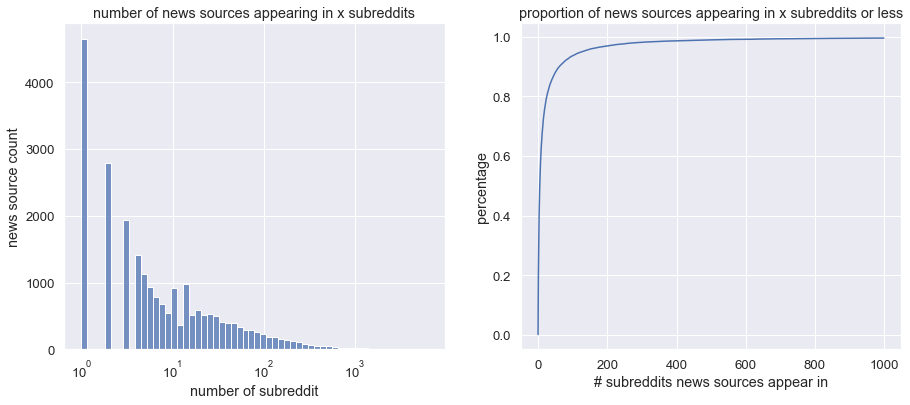

In [295]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
sns.set(font_scale = 1.2)

sns.histplot(scf, log_scale=True, ax=ax1)
ax1.set_xlabel("number of subreddit")
ax1.set_ylabel("news source count")
ax1.set_title("number of news sources appearing in x subreddits")

sns.lineplot(x=[k[0] for k in pct_in_k_subreddits],
             y=[k[1] for k in pct_in_k_subreddits],
            ax=ax2)
ax2.set_ylabel("percentage")
ax2.set_xlabel("# subreddits news sources appear in")
ax2.set_title("proportion of news sources appearing in x subreddits or less")

In [296]:
# mean
statistics.mean(scf)

33.98843371467026

In [297]:
# median
statistics.median(scf)

5.0

## For each news source let's count how many times they are shared regardless of in which subreddits

In [298]:
sum(dict().values())

0

In [299]:
def get_mention_count(ns):
    """get total mention count of ns in all six months"""
    count = 0
    files = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]
    for f in files:
        ns_dict = f.get(ns, dict())
        if len(ns_dict) > 0:
            mentions = sum([m[0] for m in ns_dict.values()])
            count += mentions
    return count

In [300]:
mention_count = dict()
for ns in ns_union:
    mention_count[ns] = get_mention_count(ns)

In [301]:
statistics.mean(mention_count.values())

301.5175807537012

In [302]:
statistics.stdev(mention_count.values())

3829.903313287895

In [303]:
statistics.median(mention_count.values())

10.0

In [304]:
len(mention_count)

23776

In [305]:
Counter(mention_count).most_common(100)

[('mlb.com', 318989),
 ('theguardian.com', 226912),
 ('cnn.com', 161294),
 ('nytimes.com', 145271),
 ('foxnews.com', 141964),
 ('bbc.co.uk', 88674),
 ('thehindu.com', 88434),
 ('thestar.com', 87727),
 ('reuters.com', 85396),
 ('nypost.com', 81821),
 ('cnbc.com', 65997),
 ('thehill.com', 63676),
 ('indiatimes.com', 63208),
 ('washingtontimes.com', 59950),
 ('breitbart.com', 57689),
 ('usatoday.com', 54326),
 ('cbc.ca', 52741),
 ('scmp.com', 52591),
 ('apnews.com', 48804),
 ('nbcnews.com', 48612),
 ('aljazeera.com', 47879),
 ('fandom.com', 47242),
 ('mb.com.ph', 45685),
 ('dailymail.co.uk', 44498),
 ('independent.co.uk', 44067),
 ('washingtonpost.com', 43519),
 ('cloudinary.com', 41704),
 ('newsweek.com', 41029),
 ('bbc.com', 40852),
 ('npr.org', 39973),
 ('nhl.com', 38797),
 ('cointelegraph.com', 38640),
 ('espn.com', 38021),
 ('latimes.com', 36450),
 ('smh.com.au', 34496),
 ('businessinsider.com', 34135),
 ('bloomberg.com', 33967),
 ('cbsnews.com', 33711),
 ('irishtimes.com', 33356),
 

In [306]:
news_ge10k = [m for m in mention_count if mention_count[m] >= 1000]
len(news_ge10k)

829

In [307]:
with open("news_ge10k.csv", "w", encoding="utf-8", newline='') as n:
    w = csv.writer(n, dialect="excel", delimiter=",")
    for e in news_ge10k:
        w.writerow([e])

In [308]:
ns_subreddit_01['cbc.ca']

{'todayilearned': [17, 14.780000000000001, 2038],
 'JoeRogan': [1, 0.76, 3],
 'knowyourshit': [3, 2.92, 1],
 'collapse': [7, 6.280000000000001, 58],
 'marginal': [3, 3.0, 0],
 'conspiracy': [11, 8.9, 649],
 'politics': [121, 107.37999999999998, 227661],
 'CPTSD': [1, 1.0, 1],
 'VideoEditing': [1, 0.98, 38],
 'wallstreetbets': [15, 13.129999999999999, 115],
 'hackernews': [8, 5.92, 8],
 'patient_hackernews': [8, 8.0, 8],
 'unitedkingdom': [2, 1.82, 19],
 'Catholicism': [1, 1.0, 2],
 'bprogramming': [1, 1.0, 0],
 'books': [6, 5.2, 15],
 'hackerdigest': [1, 1.0, 0],
 'Snorkblot': [2, 2.0, 2],
 'UnresolvedMysteries': [18, 17.439999999999998, 1033],
 'TrueUnpopularOpinion': [2, 1.3, 32],
 'SPACs': [2, 1.8, 152],
 'aznidentity': [1, 0.98, 40],
 'badgovnofreedom': [34, 34.0, 1],
 'cyberpunkgame': [1, 0.4, 3],
 'CBC_': [9, 8.84, 1],
 'newjersey': [1, 0.8, 25],
 'newfoundland': [28, 25.439999999999994, 406],
 'Hamilton': [42, 35.79, 950],
 'mildlyinteresting': [1, 1.0, 0],
 'Oshawa': [1, 0.9, 5

<AxesSubplot:ylabel='Count'>

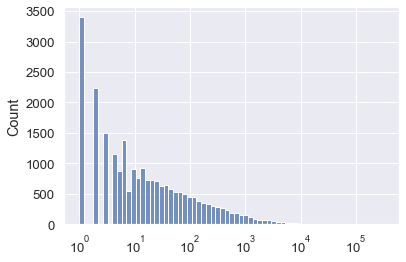

In [309]:
sns.histplot(list(mention_count.values()), log_scale=True)

In [310]:
len([k for k in mention_count.values() if k <5])*100/len(mention_count)

34.91335800807537

In [311]:
(1-0.35)*len(mention_count)

15454.4

## For each subreddit let's count how many news sources were mentioned in it

Counting how many news sources were mentioned in each subreddit

In [312]:
nsc_count = dict()
for sr in sr_union:
    nsc_count[sr] = len(set(subreddit_ns_jan.get(sr, dict()).keys()) 
                               | set(subreddit_ns_feb.get(sr, dict()).keys()) 
                               | set(subreddit_ns_march.get(sr, dict()).keys()) 
                               | set(subreddit_ns_april.get(sr, dict()).keys())
                               | set(subreddit_ns_may.get(sr, dict()).keys()) 
                               | set(subreddit_ns_jun.get(sr, dict()).keys()))

`nsc_count` stores how many news sources appear in each subreddit.

In [313]:
nsc_count['aww']

104

In [314]:
len([k for k in nsc_count if nsc_count[k]<1])

0

In [315]:
nsc_count_freq = dict(Counter(nsc_count.values()).most_common())
nsc_count_freq

{1: 29027,
 2: 9640,
 3: 5413,
 4: 3443,
 5: 2422,
 6: 1990,
 7: 1491,
 8: 1286,
 9: 1068,
 10: 897,
 11: 745,
 12: 637,
 13: 612,
 14: 524,
 16: 436,
 15: 419,
 18: 377,
 17: 364,
 19: 329,
 20: 319,
 22: 254,
 21: 250,
 25: 216,
 23: 216,
 24: 214,
 27: 194,
 26: 178,
 29: 175,
 28: 164,
 30: 151,
 32: 143,
 31: 138,
 33: 134,
 35: 120,
 34: 119,
 37: 110,
 36: 109,
 39: 103,
 40: 98,
 42: 83,
 43: 79,
 41: 79,
 38: 77,
 49: 76,
 44: 76,
 52: 74,
 45: 68,
 51: 66,
 47: 63,
 53: 62,
 48: 61,
 46: 58,
 50: 58,
 59: 53,
 56: 53,
 55: 53,
 58: 46,
 61: 44,
 54: 43,
 63: 43,
 62: 41,
 66: 40,
 67: 36,
 57: 36,
 77: 35,
 68: 35,
 64: 35,
 60: 34,
 71: 33,
 80: 33,
 65: 33,
 74: 31,
 82: 29,
 73: 28,
 69: 28,
 88: 27,
 70: 27,
 72: 27,
 75: 26,
 86: 24,
 93: 23,
 81: 22,
 78: 22,
 85: 22,
 84: 21,
 83: 21,
 76: 20,
 91: 20,
 110: 20,
 79: 20,
 87: 20,
 89: 19,
 101: 19,
 97: 18,
 103: 18,
 94: 18,
 116: 18,
 104: 18,
 118: 17,
 98: 17,
 140: 15,
 124: 15,
 107: 15,
 112: 15,
 95: 15,
 132: 

`nsc_count_freq` keeps track of how many news sources appear in *n* subreddits for all possible *n*.

In [316]:
max(nsc_count_freq.keys())

3603

In [317]:
nsc_ranked = Counter(nsc_count).most_common()

for t in nsc_ranked:
    sr, co = t
    if co > 1200:
        print(f"{sr} has {co} news sources mentioned in it.")

COVID_CANADA has 3603 news sources mentioned in it.
news has 3452 news sources mentioned in it.
politics has 3044 news sources mentioned in it.
todayilearned has 2949 news sources mentioned in it.
Coronavirus has 2613 news sources mentioned in it.
worldnews has 2564 news sources mentioned in it.
nottheonion has 2444 news sources mentioned in it.
prisons has 2309 news sources mentioned in it.
NoFilterNews has 2255 news sources mentioned in it.
conspiracy has 2099 news sources mentioned in it.
wallstreetbets has 1999 news sources mentioned in it.
tomorrowsworld has 1877 news sources mentioned in it.
autotldr has 1754 news sources mentioned in it.
Conservative has 1729 news sources mentioned in it.
NoNewNormal has 1592 news sources mentioned in it.
CryptoCurrency has 1543 news sources mentioned in it.
technology has 1523 news sources mentioned in it.
europe has 1432 news sources mentioned in it.
electionReformNews has 1423 news sources mentioned in it.
HumanTraffickingNews has 1338 news s

In [318]:
sum(nsc_count_freq.values()) == len(sr_union)

True

In [319]:
import itertools

In [320]:
nsc = list(itertools.chain.from_iterable(itertools.repeat(k,v) for k,v in nsc_count_freq.items()))

Text(0.5, 1.0, 'number of subreddits with x news sources')

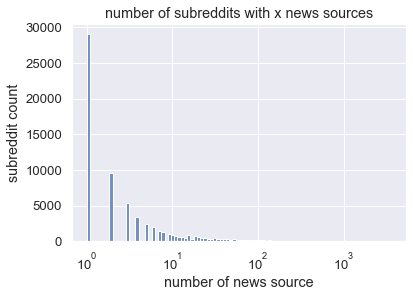

In [321]:
sns.histplot(nsc, log_scale=True)
plt.xlabel("number of news source")
plt.ylabel("subreddit count")
plt.title("number of subreddits with x news sources")

In [322]:
len([n for n in nsc if n>=20])

7104

I want to investigate and choose a subset of subreddits in the set of those that have 20 or more different news sources.

In [323]:
nsc_ge20 = []
for n in nsc_count:
    if nsc_count[n] >= 20:
        nsc_ge20.append(n)

In [324]:
len(nsc_ge20)

7104

In [325]:
import csv

In [326]:
with open("nsc_ge20.xlsx", "w", newline='', encoding="utf-8") as c:
    cw = csv.writer(c, delimiter=",", dialect="excel")
    for n in nsc_ge20:
        cw.writerow([n,"https://www.reddit.com/r/{}".format(n)])

In [327]:
"learnwelsh" in sr_union

True

In [328]:
subreddit_ns_jan["learnwelsh"]

{'bbc.co.uk': [3, 2.93, 23],
 'mit.edu': [1, 1.0, 0],
 'wiktionary.org': [2, 2.0, 0]}

How many subreddits only mentioned 5 news sources or less?

In [329]:
def pct_subreddits_mentioning_k_newssources(ks):
    sr_mention_i_nsc = [k for k in nsc_count if nsc_count[k] <= ks]
    count = len(sr_mention_i_nsc)
    print("There are {} subreddits mentioning in only {} news sources or less ({}%)".format(count, ks, count/len(sr_union)))
    return count/len(sr_union)

In [330]:
pct_subreddits_mentioning_k_newssources(1)

There are 29027 subreddits mentioning in only 1 news sources or less (0.42546611163227016%)


0.42546611163227016

In [331]:
# mean
statistics.mean(nsc)

11.844937265478425

In [332]:
# median
statistics.median(nsc)

2.0

## For each subreddit let's count total submissions that are news source related

In [333]:
def get_submission_count(sb):
    """get total mention count of ns in all six months"""
    count = 0
    files = [subreddit_ns_jan, subreddit_ns_feb, subreddit_ns_march, subreddit_ns_april, subreddit_ns_may, subreddit_ns_jun]
    for f in files:
        sb_dict = f.get(sb, dict())
        if len(sb_dict) > 0:
            mentions = sum([m[0] for m in sb_dict.values()])
            count += mentions
    return count

In [334]:
mention_count = dict()
for sb in sr_union:
    mention_count[sb] = get_submission_count(sb)

In [335]:
statistics.mean(mention_count.values())

105.07859404315197

In [336]:
statistics.stdev(mention_count.values())

2578.3326573709246

In [337]:
statistics.median(mention_count.values())

3.0

In [338]:
len(mention_count)

68224

In [339]:
Counter(mention_count).most_common(20)

[('AutoNewspaper', 582301),
 ('politics', 136901),
 ('TheNewsFeed', 91784),
 ('news', 84659),
 ('TrendingQuickTVnews', 82824),
 ('COVID_CANADA', 76571),
 ('worldnews', 68589),
 ('Conservative', 53943),
 ('THEHINDUauto', 44130),
 ('niuz', 43845),
 ('NoFilterNews', 43262),
 ('FakeCollegeFootball', 41241),
 ('nofeenews', 40684),
 ('TORONTOSTARauto', 39281),
 ('trendandstyle', 38133),
 ('CertifiedNews', 38011),
 ('WrestlingBreakingNews', 37277),
 ('FOXauto', 36228),
 ('NewsfeedForWork', 34863),
 ('Coronavirus', 34076)]

In [340]:
ns_subreddit_01['cbc.ca']

{'todayilearned': [17, 14.780000000000001, 2038],
 'JoeRogan': [1, 0.76, 3],
 'knowyourshit': [3, 2.92, 1],
 'collapse': [7, 6.280000000000001, 58],
 'marginal': [3, 3.0, 0],
 'conspiracy': [11, 8.9, 649],
 'politics': [121, 107.37999999999998, 227661],
 'CPTSD': [1, 1.0, 1],
 'VideoEditing': [1, 0.98, 38],
 'wallstreetbets': [15, 13.129999999999999, 115],
 'hackernews': [8, 5.92, 8],
 'patient_hackernews': [8, 8.0, 8],
 'unitedkingdom': [2, 1.82, 19],
 'Catholicism': [1, 1.0, 2],
 'bprogramming': [1, 1.0, 0],
 'books': [6, 5.2, 15],
 'hackerdigest': [1, 1.0, 0],
 'Snorkblot': [2, 2.0, 2],
 'UnresolvedMysteries': [18, 17.439999999999998, 1033],
 'TrueUnpopularOpinion': [2, 1.3, 32],
 'SPACs': [2, 1.8, 152],
 'aznidentity': [1, 0.98, 40],
 'badgovnofreedom': [34, 34.0, 1],
 'cyberpunkgame': [1, 0.4, 3],
 'CBC_': [9, 8.84, 1],
 'newjersey': [1, 0.8, 25],
 'newfoundland': [28, 25.439999999999994, 406],
 'Hamilton': [42, 35.79, 950],
 'mildlyinteresting': [1, 1.0, 0],
 'Oshawa': [1, 0.9, 5

<AxesSubplot:ylabel='Count'>

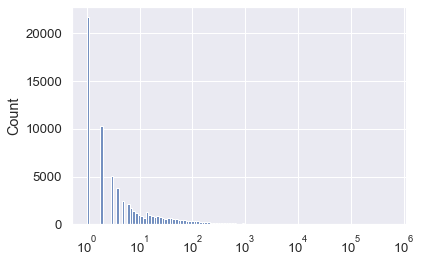

In [341]:
sns.histplot(list(mention_count.values()), log_scale=True)

<AxesSubplot:ylabel='Count'>

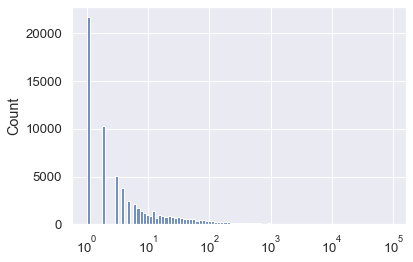

In [342]:
sns.histplot(list([k for k in mention_count.values() if k <100000]), log_scale=True)

In [343]:
len([k for k in mention_count.values() if k <5])*100/len(mention_count)

59.72824812382739

In [345]:
(1-0.60)*len(mention_count)

27289.600000000002

## upvote based weight vs comment based weight 

Do they have correlation?

Let's look at January's data

In [346]:
upvote_based = [ns_subreddit_01[ns][sr][1] for ns in ns_subreddit_01 for sr in ns_subreddit_01[ns]]
comment_based = [ns_subreddit_01[ns][sr][2] for ns in ns_subreddit_01 for sr in ns_subreddit_01[ns]]
unweighted = [ns_subreddit_01[ns][sr][0] for ns in ns_subreddit_01 for sr in ns_subreddit_01[ns]]

(-5000.0, 150000.0)

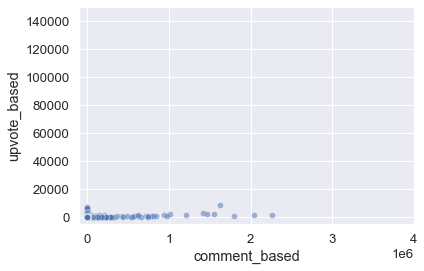

In [347]:
sns.scatterplot(x=comment_based, y=upvote_based, alpha=0.5)
plt.xlabel("comment_based")
plt.ylabel("upvote_based")
plt.xlim([-100000,4000000])
plt.ylim([-5000,150000])

Text(0, 0.5, 'upvote_based')

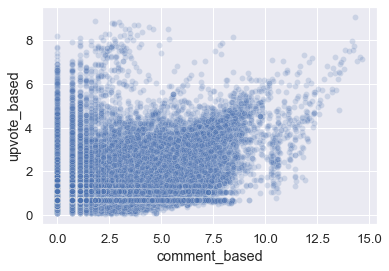

In [348]:
a = sns.scatterplot(x=np.log(np.array([c+1 for c in comment_based])), y=np.log(np.array([u+1 for u in upvote_based])), alpha=0.2)
plt.xlabel("comment_based")
plt.ylabel("upvote_based")

In [349]:
from scipy.stats import pearsonr

In [350]:
corr, _ = pearsonr(np.log(np.array([c+1 for c in comment_based])), np.log(np.array([u+1 for u in upvote_based])))
corr

0.4029222346648452

In [351]:
corr_raw, _ = pearsonr(comment_based, upvote_based)
corr_raw

0.23579230893525222

## I filter out news sources that are just too general

In [352]:
len(ns_union)

23776

In [122]:
len([k for k in ns_union if subreddit_count[k] > 1000])

63

In [123]:
non_outlier = [k for k in ns_union if subreddit_count[k] <= 1048 and subreddit_count[k] > 5]
len(non_outlier)

10898

In [124]:
subreddit_count['washingtonpost.com']

3271

In [125]:
'washingtonpost.com' in non_outlier

False

In [126]:
non_outlier

['bismarcktribune.com',
 'hottimeinoldtown.com',
 'bravesites.com',
 'trello.com',
 'warroom.org',
 'theinvestorspodcast.com',
 'albertafarmexpress.ca',
 'gametimect.com',
 'eurohoops.net',
 'rpi.edu',
 'thinkadvisor.com',
 'stirileprotv.ro',
 'gazettetimes.com',
 'arun.is',
 'watchcollectinglifestyle.com',
 'pgurus.com',
 'nexojornal.com.br',
 'aftenbladet.no',
 'westsiderag.com',
 'jpmorgan.com',
 'todayfm.com',
 'techrights.org',
 'chapelboro.com',
 'psychcongress.com',
 'impulsegamer.com',
 'ceskenoviny.cz',
 'stljewishlight.com',
 'cointrust.com',
 'exercism.io',
 'brut.media',
 'hampshirechronicle.co.uk',
 'ksltv.com',
 'smartcitiesdive.com',
 'ancientpages.com',
 'northcoastjournal.com',
 'hollywoodlife.com',
 'electricautonomy.ca',
 'ckdr.net',
 'kion546.com',
 'wreg.com',
 'military.com',
 'one37pm.com',
 'forextv.com',
 'forbes.fr',
 'grandforksherald.com',
 'aktiencheck.de',
 'canterbury.ac.nz',
 'westernstandardonline.com',
 'nbc15.com',
 'nerdwallet.com',
 'campaignlive.co

## For now as a case study I will define `non_outlier` to be some news sources from MBFC

I will take out this step later

In [96]:
mbfc_left_raw = json.load(open(os.path.join(mbfc_path, "mbfc_left.json")))
len(mbfc_left_raw)

319

In [97]:
mbfc_right_raw = json.load(open(os.path.join(mbfc_path, "mbfc_right.json")))
len(mbfc_right_raw)

254

In [100]:
mbfc_left = [m[1] for m in mbfc_left_raw if m[1]]
mbfc_right = [m[1] for m in mbfc_right_raw if m[1]]

Cleaning the URLs for both `mbfc_left` and `mbfc_right`.

In [138]:
# for mbfc_left
mbfc_left_clean = set()
for ns in mbfc_left:
    extracted = tldextract.extract(ns)
    subdomain, domain, suffix = extracted
    # add both versions of domain.suffix and subdomain.domain.suffix
    full = ""
    # with subdomain
    if len(subdomain) > 0:
        #print(f"{subdomain}.{domain}.{suffix}")
        full = f"{subdomain}.{domain}.{suffix}"
        if len(full) > 0:
            mbfc_left_clean.add(full.replace("www.","").strip('/'))
    # without subdomain
    full = f"{domain}.{suffix}"
    if len(full) > 0:
        mbfc_left_clean.add(full.replace("www.","").strip('/'))
len(mbfc_left_clean)

292

In [139]:
# for mbfc_right
mbfc_right_clean = set()
for ns in mbfc_right:
    extracted = tldextract.extract(ns)
    subdomain, domain, suffix = extracted
    # add both versions of domain.suffix and subdomain.domain.suffix
    full = ""
    # with subdomain
    if len(subdomain) > 0:
        #print(f"{subdomain}.{domain}.{suffix}")
        full = f"{subdomain}.{domain}.{suffix}"
        if len(full) > 0:
            mbfc_right_clean.add(full.replace("www.","").strip('/'))
    # without subdomain
    full = f"{domain}.{suffix}"
    if len(full) > 0:
        mbfc_right_clean.add(full.replace("www.","").strip('/'))
len(mbfc_right_clean)

232

In [140]:
non_outlier = (mbfc_left_clean | mbfc_right_clean) & set(ns_union)
len(non_outlier)

266

## Cluster Try Out

First, I make a list of subreddits with fixed order, where I only include subreddits where our non_outlier news sources are mentioned in.

In [141]:
len(non_outlier)

266

In [142]:
# subreddits = subs
subreddits = set()
nsr_files = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]
# first, I filter for only the subreddits in which our news sources are mentioned
c = 0
for n in non_outlier:
    subreddits = (subreddits | set(ns_subreddit_01.get(n, dict()).keys()) 
                               | set(ns_subreddit_02.get(n, dict()).keys()) 
                               | set(ns_subreddit_03.get(n, dict()).keys()) 
                               | set(ns_subreddit_04.get(n, dict()).keys())
                               | set(ns_subreddit_05.get(n, dict()).keys()) 
                               | set(ns_subreddit_06.get(n, dict()).keys()))
    c += 1
    if c%100==0: print(f"done {c}")
subreddits = list(subreddits)
len(subreddits)

done 100
done 200


11128

There are 9195 subreddits.

In [143]:
subreddits[-10:]

['BillGatesBeingAwesome',
 'Nationals',
 'GenX',
 'Testosterone',
 'BeeGees',
 'NewYorkForSanders',
 'FreeKarma4U',
 'mazzystar',
 'turtleswithjobs',
 'vim']

If I should order them later, I can do so.

## Incorporating subscribers information

In [144]:
pd1 = os.path.split(os.getcwd())[0]
data_fp = os.path.join(pd1,"data/gm-newssources-subreddits")
dfp = os.path.join(pd1,"data")

In [145]:
sfp = os.path.join(pd1,"data/subreddits")

In [146]:
# Let's only use the subreddits that have lots of subscribers
with open (os.path.join(sfp,"subreddit_subscribers.json"), "r", encoding = "utf-8") as infile:
    subreddit_subscribers = json.load(infile)

In [147]:
subreddit_subscribers['politics']

6201779

In [148]:
len(subreddit_subscribers)

49055

In [149]:
len(subreddits)

11128

In [150]:
subreddits_w_subc = [k for k in subreddits if k in subreddit_subscribers]
len(subreddits_w_subc)

8455

It seems that there are `None` values, so let's filter those subreddits out.

In [151]:
print([s for s in subreddits_w_subc if subreddit_subscribers[s] is None])

['LoveForLandlords', 'DystopianFuture', 'RedditMobTest', 'JKRowling']


In [152]:
subreddits_w_subc = [s for s in subreddits_w_subc if subreddit_subscribers[s] is not None]

In [153]:
len(subreddits_w_subc)

8451

Now, I will sort the 8,294 subreddits based on the # of their subscribers in a descending order.

In [154]:
srs_all = sorted(subreddits_w_subc, key= lambda x: subreddit_subscribers[x], reverse= True)

Text(0.5, 1.0, 'Subreddits Subscribers')

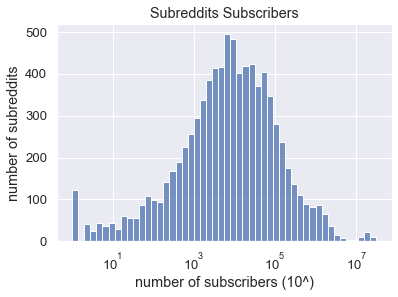

In [155]:
# plt.hist([math.log(subreddit_subscribers[s],10) for s in srs_all if subreddit_subscribers[s] > 0])
sns.histplot([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s]>0], log_scale=True)
# plt.hist([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s] > 0])
# plt.yscale("log")
# plt.xscale("log")
plt.ylabel("number of subreddits")
plt.xlabel("number of subscribers (10^)")
plt.title("Subreddits Subscribers")
# log scale for both x and y

Which subreddits are the top three?

In [156]:
print([(s,subreddit_subscribers[s]) for s in srs_all if subreddit_subscribers[s]>25000000])

[('funny', 31060166), ('gaming', 26628444), ('aww', 25197817)]


In [157]:
dir(math)

['__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'acos',
 'acosh',
 'asin',
 'asinh',
 'atan',
 'atan2',
 'atanh',
 'ceil',
 'comb',
 'copysign',
 'cos',
 'cosh',
 'degrees',
 'dist',
 'e',
 'erf',
 'erfc',
 'exp',
 'expm1',
 'fabs',
 'factorial',
 'floor',
 'fmod',
 'frexp',
 'fsum',
 'gamma',
 'gcd',
 'hypot',
 'inf',
 'isclose',
 'isfinite',
 'isinf',
 'isnan',
 'isqrt',
 'ldexp',
 'lgamma',
 'log',
 'log10',
 'log1p',
 'log2',
 'modf',
 'nan',
 'perm',
 'pi',
 'pow',
 'prod',
 'radians',
 'remainder',
 'sin',
 'sinh',
 'sqrt',
 'tan',
 'tanh',
 'tau',
 'trunc']

In [158]:
list(subreddit_subscribers.values()).count(None)

25

In [159]:
statistics.median([k for k in list(subreddit_subscribers.values()) if k is not None])

1420.0

In [160]:
statistics.mean([k for k in list(subreddit_subscribers.values()) if k is not None])

50070.832184376915

## Building `ns_repr`

Which will be in the form of feature-based matrix, where each row represents a news source, and columns representing subreddits. Each subreddit will be represented by 18 columns: unweighted count, upvote based weighted count, and comment based weighted count for each of the six months that we are interested in.

In [161]:
srs = srs_all

In [162]:
a = {"a": 1, "b": 2}
b = {"b": 1, "c": 2}
res = {**a, **b}
res

{'a': 1, 'b': 1, 'c': 2}

For each news source, I create a list of length `(3 * # subreddits)`.

Old code
```
# here I will cast the inner dictionaries of ns_subreddits to be Counter so I can avoid a lot of if-else statements
files = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]
for f in files:
    for k in f: # k is each news source
        for ns in f[k]:
            # averaging based on weighted counts
            count, upv, comm = f[k][ns]
            avg = (upv + comm)/count
            f[k][ns] = avg
        f[k] = Counter(f[k])
```

In [163]:
files_sub = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]

In [164]:
len(non_outlier)

266

In [165]:
len(srs)

8451

I tried and found out that using all 23.7k subreddits results in MemoryError. So I should use less

In [206]:
srs = srs_all[:5000]

In [234]:
ns_sr_rep = defaultdict(list)
default_counter = Counter() # to avoid a lot of if else statements

ncount = 0

# for ns in nss:
for ns in non_outlier:
    # for each news sources, construct the 18*length(subreddits) features
    for f in files_sub:
        for idx in range(len(srs)):
            # making sure the ordering follows `srs` based on subscribers
            ns_sr_rep[ns] += f[ns][srs[idx]][1:] if (ns in f and srs[idx] in f[ns]) else [0, 0]
    ncount += 1
    if ncount%200==0: print(ncount)

200


    code started at 22:56

Let's see one example of representation for `nytimes.com`.

In [235]:
len(ns_sr_rep['amsterdamnews.com'])

60000

Let's investigate the sparsity of our data

In [236]:
from numpy import array
from numpy import count_nonzero
from scipy.sparse import csr_matrix

In [237]:
# ns_repr, ns_fixed = np.array([v[1] for v in items]), list([v[0] for v in items]) # this causes memory error
## MemoryError: Unable to allocate 15.3 GiB for an array with shape (11436, 180000) and data type float64
items = ns_sr_rep.items()
ns_repr = np.array([v[1] for v in items])

In [238]:
sparsity = 1.0 - np.count_nonzero(ns_repr)/ns_repr.size

In [239]:
sparsity

0.9944756265664161

Wow very high sparsity.

In [240]:
# convert to sparse matrix (CSR method)
S = csr_matrix(ns_repr)
print(S)

  (0, 24492)	1.22
  (0, 24493)	6.0
  (0, 24982)	1.68
  (0, 24983)	8.0
  (0, 33258)	1.34
  (0, 33259)	4.0
  (0, 35526)	1.0
  (0, 40716)	0.3
  (0, 40717)	3.0
  (0, 42920)	0.92
  (0, 42921)	25.0
  (0, 45136)	0.57
  (0, 45137)	2.0
  (0, 52920)	1.0
  (0, 52921)	9.0
  (0, 54792)	1.66
  (0, 54793)	6.0
  (0, 58094)	1.82
  (0, 58095)	6.0
  (1, 386)	0.5
  (1, 406)	0.54
  (1, 407)	2.0
  (1, 1068)	0.62
  (1, 1069)	2.0
  (1, 1732)	0.86
  :	:
  (265, 29212)	0.92
  (265, 29213)	1.0
  (265, 33876)	0.97
  (265, 33877)	88.0
  (265, 35262)	0.84
  (265, 35263)	1.0
  (265, 35508)	0.9
  (265, 35509)	3.0
  (265, 38112)	0.98
  (265, 38113)	25.0
  (265, 38688)	0.98
  (265, 38689)	4.0
  (265, 42990)	1.86
  (265, 42991)	18.0
  (265, 44756)	0.99
  (265, 44757)	5.0
  (265, 46054)	1.34
  (265, 46055)	42.0
  (265, 51260)	1.0
  (265, 55152)	1.0
  (265, 55153)	4.0
  (265, 57040)	0.87
  (265, 57041)	17.0
  (265, 58168)	1.0
  (265, 58169)	11.0


### Now PCA

In [241]:
# svd = TruncatedSVD(n_components=len(srs)) #, n_iter=7, random_state=42)
svd = PCA(n_components=len(ns_repr))

In [242]:
svd.fit(ns_repr)

PCA(n_components=266)

In [243]:
explained_var = svd.explained_variance_ratio_

In [244]:
len(explained_var)

266

In [245]:
svd.explained_variance_ratio_.sum()

0.9999999999999999

In [246]:
explained_var_sums = [sum(explained_var[:d]) for d in range(len(ns_repr))]

c:\users\user200803\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

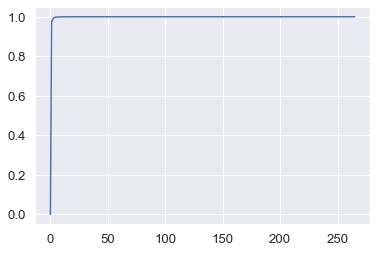

In [247]:
sns.lineplot(range(len(explained_var_sums)), explained_var_sums)

Now, I will cast those list representation values to be numpy arrays so I can preprocess them easily. Further, I will normalize each array.

*side note: `preprocessing.normalize` vs `standardscaler`*

In [160]:
preprocessing.normalize(np.array([[1,100,2,3]]))

array([[0.00999301, 0.99930073, 0.01998601, 0.02997902]])

In [161]:
scaler = StandardScaler()
scaler.fit_transform(np.array([[1,100,2,3]]))

array([[0., 0., 0., 0.]])

Now I'm thinking, should I *normalize* or *standardize*?

In [162]:
# for ns in ns_sr_rep:
#     rep = ns_sr_rep[ns]
#     ns_sr_rep[ns] = preprocessing.normalize(np.array([rep]))

## K-Means

Without standardization.

First, I need to find optimum `k`.

In [163]:
kmeans = KMeans(init = "k-means++",
               n_clusters = 5,
               n_init = 10,
               max_iter = 100)

Freezing the list for representations and the news sources.

In [166]:
kmeans.fit([v for v in ns_sr_rep.values()])

KMeans(max_iter=100, n_clusters=5)

In [167]:
for i,ns in enumerate(ns_fixed):
    if (ns_sr_rep[ns] == ns_repr[i]).all():
        pass
    else:
        print("False")
print("True")

True


In [168]:
kmeans.inertia_

9826851082.529928

In [169]:
kmeans.n_iter_

6

In [170]:
Counter(kmeans.labels_)

Counter({0: 11357, 1: 12, 4: 63, 3: 1, 2: 3})

**Choosing the appropriate number of clusters**

1. Elbow method

In [171]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 360
}

In [172]:
sse = []
for k in range(1,20):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(ns_repr)
    sse.append(kmeans.inertia_)
    print(f"have done {k} rounds, current sse is {sse}")

have done 1 rounds, current sse is [23449436924.745914]
have done 2 rounds, current sse is [23449436924.745914, 16403619369.069223]
have done 3 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112]
have done 4 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112, 12545894031.450285]
have done 5 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112, 12545894031.450285, 11272340605.480078]
have done 6 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112, 12545894031.450285, 11272340605.480078, 9206299986.068668]
have done 7 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112, 12545894031.450285, 11272340605.480078, 9206299986.068668, 8944935005.953146]
have done 8 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112, 12545894031.450285, 11272340605.480078, 9206299986.068668, 8944935005.953146, 8371371167.842005

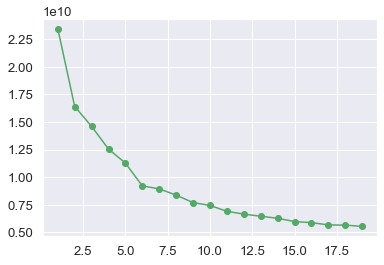

In [173]:
plt.plot(range(1,20),sse,"go-")

In [174]:
for k in range(20,41):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(ns_repr)
    sse.append(kmeans.inertia_)
    print(f"have done {k} rounds, current sse is {sse}")

have done 20 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112, 12545894031.450285, 11272340605.480078, 9206299986.068668, 8944935005.953146, 8371371167.842005, 7697802761.991763, 7439467031.309094, 6909310699.419428, 6654306963.26893, 6460188757.661017, 6276347552.998721, 5979781661.205648, 5881229904.03242, 5676602292.103157, 5656836846.585837, 5538944833.53924, 5264175921.681719]
have done 21 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112, 12545894031.450285, 11272340605.480078, 9206299986.068668, 8944935005.953146, 8371371167.842005, 7697802761.991763, 7439467031.309094, 6909310699.419428, 6654306963.26893, 6460188757.661017, 6276347552.998721, 5979781661.205648, 5881229904.03242, 5676602292.103157, 5656836846.585837, 5538944833.53924, 5264175921.681719, 5177587995.900417]
have done 22 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112, 12545894031.450285, 11272340605.480078, 920629

have done 35 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112, 12545894031.450285, 11272340605.480078, 9206299986.068668, 8944935005.953146, 8371371167.842005, 7697802761.991763, 7439467031.309094, 6909310699.419428, 6654306963.26893, 6460188757.661017, 6276347552.998721, 5979781661.205648, 5881229904.03242, 5676602292.103157, 5656836846.585837, 5538944833.53924, 5264175921.681719, 5177587995.900417, 5076006046.41951, 5026174131.257136, 4901619684.296674, 4882122799.429097, 4832986116.720473, 4710014917.251001, 4690824268.634267, 4586651962.452597, 4418465371.553158, 4423859659.081299, 4339081133.524831, 4264385831.917897, 4239911818.1692686, 4098709969.3477373]
have done 36 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112, 12545894031.450285, 11272340605.480078, 9206299986.068668, 8944935005.953146, 8371371167.842005, 7697802761.991763, 7439467031.309094, 6909310699.419428, 6654306963.26893, 6460188757.661017, 6276347

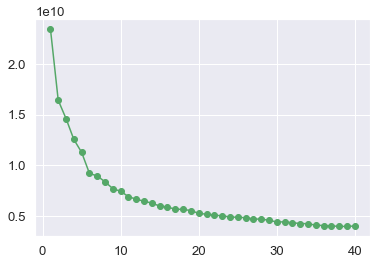

In [175]:
plt.plot(range(1,41),sse,"go-")

In [176]:
kl = KneeLocator(range(1,41), sse, curve="convex", direction="decreasing")

In [177]:
kl.elbow

11

**Using Silhouette Coefficient**

In [178]:
sc = []
new_sse = []
for k in range(2,30):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(ns_repr)
    score = silhouette_score(ns_repr, kmeans.labels_)
    sc.append(score)
    new_sse.append(kmeans.inertia_)
    print("step {}".format(k))

step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29


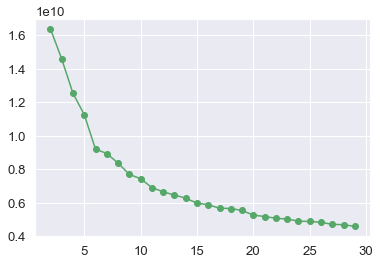

In [180]:
# for sse
plt.plot(range(2,30), new_sse, "go-")

In [181]:
kl_new = KneeLocator(range(2,30), new_sse, curve="convex", direction="decreasing")
kl_new.elbow

11

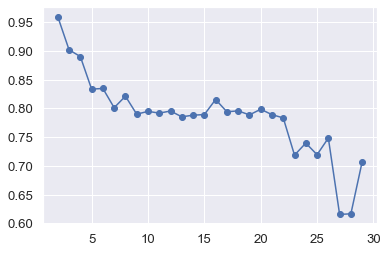

In [182]:
# for silhouette coefficient
plt.plot(range(2,30), sc, "bo-")

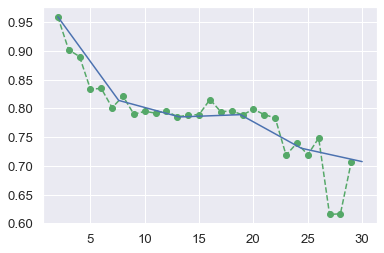

In [184]:


spl = make_interp_spline(range(2,30), sc, k=3)  # type: BSpline

xs = np.linspace(2, 30, 6)
ys = spl(xs)

plt.plot(range(2,30), sc, "go--")
plt.plot(xs, ys, "b-")

Let's choose k = 10

In [185]:
kmeans = KMeans(n_clusters = 8, init="k-means++", n_init = 50, max_iter = 500, random_state = 360)
kmeans.fit(ns_repr)

KMeans(max_iter=500, n_init=50, random_state=360)

In [68]:
dir(kmeans)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_algorithm',
 '_check_feature_names',
 '_check_mkl_vcomp',
 '_check_n_features',
 '_check_params',
 '_check_test_data',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_init_centroids',
 '_more_tags',
 '_n_init',
 '_n_threads',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_tol',
 '_transform',
 '_validate_center_shape',
 '_validate_data',
 'algorithm',
 'cluster_centers_',
 'copy_x',
 'fit',
 'fit_predict',
 'fit_transform',
 'get_params',
 'inertia_',
 'init',
 'labels_',
 'max_iter',
 'n_clusters',
 'n_features_in_',
 'n_init',
 'n_iter_',
 'predict',
 'random_

In [186]:
kmeans.labels_

array([7, 7, 7, ..., 7, 7, 7])

In [187]:
set(kmeans.labels_)

{0, 1, 2, 3, 4, 5, 6, 7}

In [188]:
Counter(kmeans.labels_)

Counter({7: 11200, 0: 96, 3: 110, 1: 5, 4: 1, 2: 3, 6: 20, 5: 1})

**Let's investigate each cluster**

In [317]:
len(ns_sr_rep)

12172

In [318]:
len(kmeans.labels_)

12172

In [319]:
clustered = defaultdict(list)
for idx,ns in enumerate(ns_fixed):
    c = kmeans.labels_[idx]
    clustered[c].append(ns)

In [320]:
print([len(clustered[i]) for i in range(10)])

[11739, 20, 177, 82, 103, 1, 13, 37, 0, 0]


Let's see in terms of percentage

In [321]:
cluster_lens = [len(clustered[i]) for i in range(10)]

In [322]:
print([round(k*100/sum(cluster_lens),2) for k in cluster_lens])

[96.44, 0.16, 1.45, 0.67, 0.85, 0.01, 0.11, 0.3, 0.0, 0.0]


 **could do iterative clusters for ^**

In [325]:
clustered[2]

['opb.org',
 'actionnewsnow.com',
 'okcfox.com',
 'wmot.org',
 'aviationweek.com',
 'vulture.com',
 'wtop.com',
 'jns.org',
 'dutchnews.nl',
 'woodworkingnetwork.com',
 'wvmetronews.com',
 'nbc-2.com',
 'nbc12.com',
 'fox2detroit.com',
 'wvnstv.com',
 'thelily.com',
 'kbzk.com',
 'kktv.com',
 'rentonreporter.com',
 'montreal.ctvnews.ca',
 'nbcchicago.com',
 'nwaonline.com',
 'theadvocate.com',
 'whdh.com',
 'expressnews.com',
 'fox29.com',
 'mlive.com',
 'lbc.co.uk',
 'uptownmessenger.com',
 'nbcsports.com',
 'duluthnewstribune.com',
 'wfmj.com',
 'fox26houston.com',
 'abc15.com',
 'abc30.com',
 'toronto.citynews.ca',
 'wqow.com',
 'kiro7.com',
 'wgem.com',
 'prpeak.com',
 'denverpost.com',
 'kpvi.com',
 'fox4news.com',
 'desmoinesregister.com',
 'metrotimes.com',
 'local12.com',
 'fox7austin.com',
 'tmj4.com',
 'theregister.com',
 'news4sanantonio.com',
 'govexec.com',
 'fox11online.com',
 'wearemitu.com',
 'wsvn.com',
 'wafb.com',
 'nzherald.co.nz',
 'fox21news.com',
 'chicagocrusade

## DBSCAN clustering

In [326]:
from sklearn.cluster import DBSCAN

First try out.

In [327]:
dbscan = DBSCAN(eps=0.01)

In [328]:
ds_clusters = dbscan.fit(ns_repr)

In [329]:
dbs_labels = ds_clusters.labels_
len(dbs_labels)

12172

In [330]:
np.unique(dbs_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37], dtype=int64)

In [331]:
dbscan_clusters = defaultdict(list)
for idx, c in enumerate(list(dbs_labels)):
    dbscan_clusters[c].append(ns_fixed[idx])

In [332]:
for c in range(-1, 38):
    print("number of ns in cluster {}: {}".format(c, len(dbscan_clusters[c])))

number of ns in cluster -1: 6236
number of ns in cluster 0: 5206
number of ns in cluster 1: 13
number of ns in cluster 2: 102
number of ns in cluster 3: 22
number of ns in cluster 4: 6
number of ns in cluster 5: 12
number of ns in cluster 6: 192
number of ns in cluster 7: 7
number of ns in cluster 8: 31
number of ns in cluster 9: 53
number of ns in cluster 10: 37
number of ns in cluster 11: 5
number of ns in cluster 12: 20
number of ns in cluster 13: 17
number of ns in cluster 14: 5
number of ns in cluster 15: 26
number of ns in cluster 16: 8
number of ns in cluster 17: 5
number of ns in cluster 18: 5
number of ns in cluster 19: 6
number of ns in cluster 20: 12
number of ns in cluster 21: 8
number of ns in cluster 22: 24
number of ns in cluster 23: 5
number of ns in cluster 24: 13
number of ns in cluster 25: 7
number of ns in cluster 26: 5
number of ns in cluster 27: 6
number of ns in cluster 28: 10
number of ns in cluster 29: 5
number of ns in cluster 30: 5
number of ns in cluster 31:

Let's investigate some of the clusters

In [342]:
dbscan_clusters[9]

['smdailyjournal.com',
 'news-gazette.com',
 'sakshi.com',
 'tortoisemedia.com',
 'berlingske.dk',
 'eleconomista.com.mx',
 'letelegramme.fr',
 'odishatv.in',
 'moneylife.in',
 'thelastamericanvagabond.com',
 'hankookilbo.com',
 'ekstrabladet.dk',
 'todayheadline.co',
 'wellnessmama.com',
 'ticotimes.net',
 'eldiariony.com',
 'carehome.co.uk',
 'phnompenhpost.com',
 'mediafax.ro',
 'rcrwireless.com',
 'wigantoday.net',
 'parismatch.com',
 'biznews.com',
 'vedomosti.ru',
 'iz.ru',
 'dailycardinal.com',
 'fashionweekdaily.com',
 'searchenginewatch.com',
 'techinasia.com',
 'azernews.az',
 'surfacemag.com',
 'animalpolitico.com',
 'icirnigeria.org',
 'salaamgateway.com',
 'n-tv.de',
 'vavel.com',
 'myfitnesspal.com',
 'thecitizen.com',
 '2gb.com',
 'dopemagazine.com',
 'livehindustan.com',
 'niagarathisweek.com',
 'lowyat.net',
 'kbjr6.com',
 'smartinsights.com',
 'theglobalist.com',
 'atheistrepublic.com',
 'dinheirovivo.pt',
 'sabah.com.tr',
 'lenta.ru',
 'goldswitzerland.com',
 'mounta

In [147]:
dbscan_clusters[1]

[]

**Finding optimum `epsilon` for dbscan**

References: 

https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

In [343]:
from sklearn.neighbors import NearestNeighbors

In [344]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(ns_repr)
distances, indices = nbrs.kneighbors(ns_repr)

(0.0, 0.01)

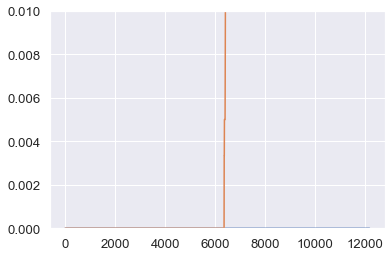

In [348]:
distances = np.sort(distances, axis=0)
# distances = distances[:,1]
plt.plot(distances)
plt.ylim((0,0.01))

I don't think any epsilon makes sense here.